In [1]:
import time
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
import scipy
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import RANSACRegressor, LinearRegression, TheilSenRegressor
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
import seaborn
from IPython.display import Image
import copy

C:\Users\MyPC\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\MyPC\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\MyPC\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Feature Exploration

In [2]:
data = pd.read_excel('Concrete_Data.xls')
print(len(data))
data.head()

1030


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [3]:
# rename columns
data.columns = ['cement_component', 'furnace_slag', 'fly_ash', 'water_component', 'superplasticizer',
               'coarse_aggregate', 'fine_aggregate', 'age', 'concrete_strength']
data.head()

,cement_component,furnace_slag,fly_ash,water_component,superplasticizer,coarse_aggregate,fine_aggregate,age,concrete_strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


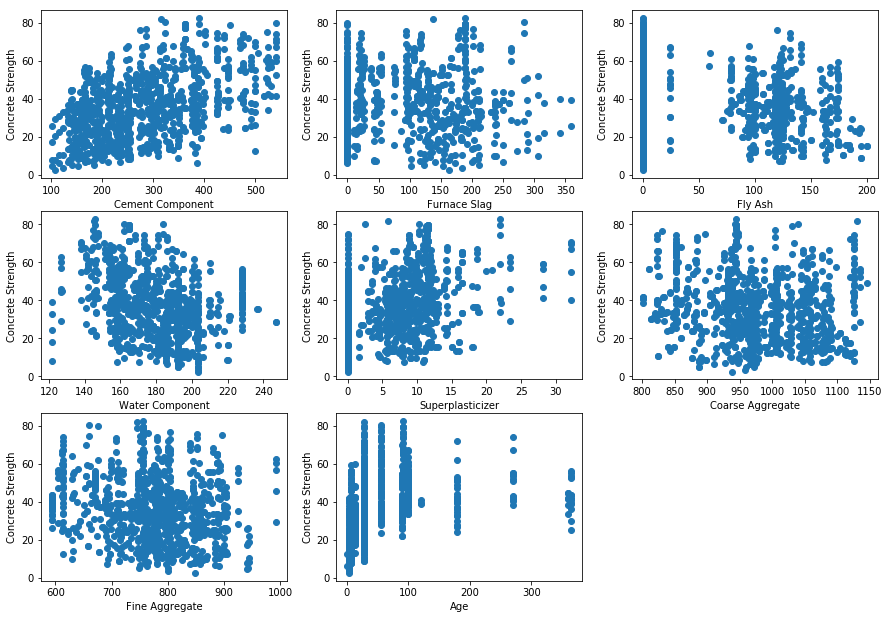

In [4]:
plt.figure(figsize=(15,10.5))
plot_count = 1
for feature in list(data.columns)[:-1]:
    plt.subplot(3,3,plot_count)
    plt.scatter(data[feature], data['concrete_strength'])
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel('Concrete Strength')
    plot_count += 1
    
plt.show()

In [5]:
# calculating the Pair-wise pearson correlations
data_1 = copy.deepcopy(data)
pd.set_option('display.width', 100)
pd.set_option('precision', 3)
data_ = data_1[(data_1.T != 0).any()]
correlations = data_.corr(method='pearson')
print(correlations)

                   cement_component  furnace_slag  fly_ash  water_component  superplasticizer  \
cement_component              1.000        -0.275   -0.397           -0.082             0.093   
furnace_slag                 -0.275         1.000   -0.324            0.107             0.043   
fly_ash                      -0.397        -0.324    1.000           -0.257             0.377   
water_component              -0.082         0.107   -0.257            1.000            -0.657   
superplasticizer              0.093         0.043    0.377           -0.657             1.000   
coarse_aggregate             -0.109        -0.284   -0.010           -0.182            -0.266   
fine_aggregate               -0.223        -0.282    0.079           -0.451             0.223   
age                           0.082        -0.044   -0.154            0.278            -0.193   
concrete_strength             0.498         0.135   -0.106           -0.290             0.366   

                   coarse_agg

C:\Users\MyPC\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


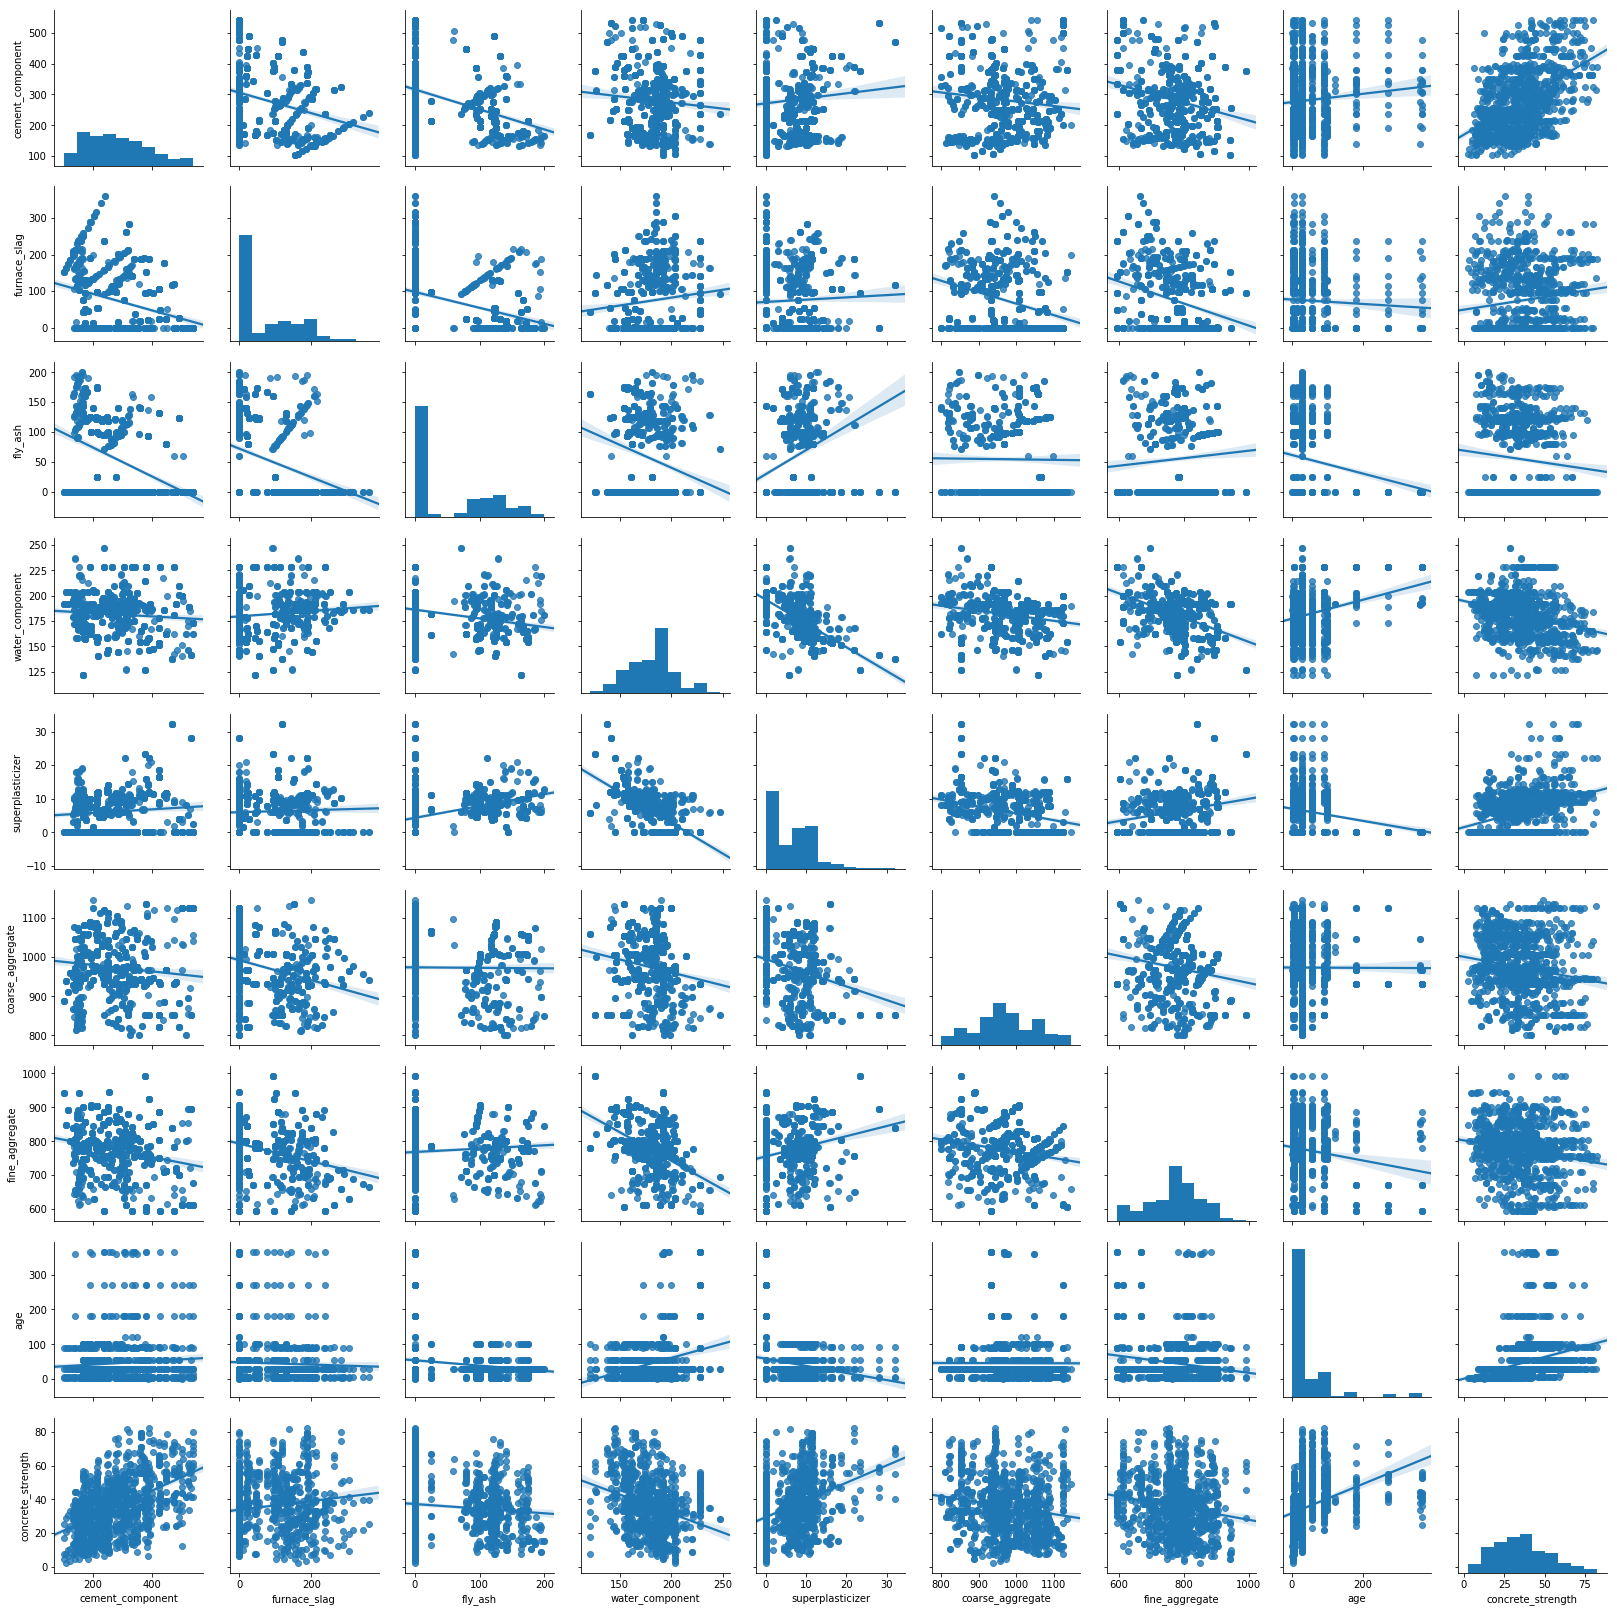

In [6]:
# calculate pair plot between all features
data_ = data_1[(data_1.T != 0).any()]
seaborn.pairplot(data_, vars=data.columns, kind='reg')
plt.show()

# Training Data

In [7]:
def split_train_test(data, feature, train_index=0.7):
    train, test = train_test_split(data, test_size=1-train_index)
    
    if type(feature) == list:
        x_train = train[feature].as_matrix()
        y_train = train['concrete_strength'].as_matrix()
        
        x_test = test[feature].as_matrix()
        y_test = test['concrete_strength'].as_matrix()
        
    else:
        x_train = [[x] for x in list(train[feature])]
        y_train = [[x] for x in list(train['concrete_strength'])]
        
        x_test = [[x] for x in list(test[feature])]
        y_test = [[x] for x in list(test['concrete_strength'])]
        
    return x_train, y_train, x_test, y_test

# Linear Regression

cement_component 0.2863838820484599
fly_ash 0.03804949709266092
water_component 0.09118822208361332
superplasticizer 0.06705871617385117
coarse_aggregate 0.03617920229771687


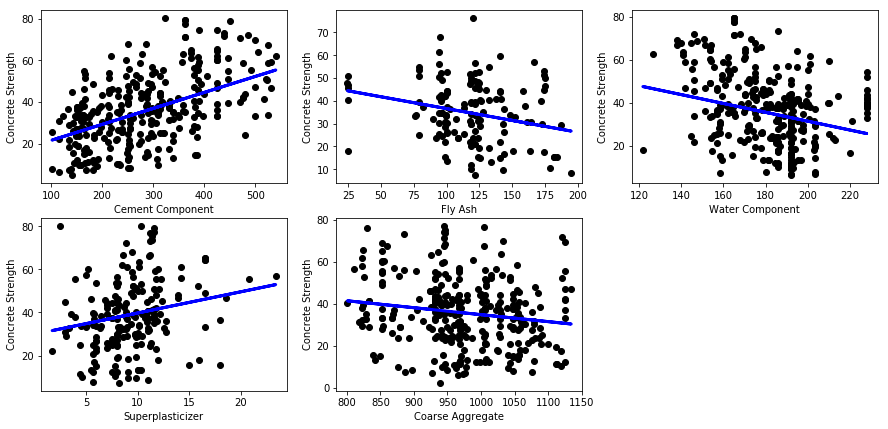

In [8]:
plt.figure(figsize=(15,7))
plot_count = 1
linear_data = copy.deepcopy(data)
for feature in ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']:
    data_tr = linear_data[['concrete_strength', feature]]
    data_tr = data_tr[(data_tr.T != 0).all()]
    
    x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
    
    # Create Linear Regression Object
    reg = LinearRegression()

    # Train Model
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)

    # Plot Outputs
    plt.subplot(2,3,plot_count)

    plt.scatter(x_test, y_test, color='black')
    plt.plot(x_test, y_pred, color='blue', linewidth=3)
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel('Concrete Strength')
    print(feature, r2_score(y_test, y_pred))

    plot_count+=1

plt.show()

# Multiple Linear Regression

Features: ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2: 0.1441312470851599
Intercept: 71.0204865219637
Coefficients: [ 0.04878308 -0.03738191 -0.15349866  0.22616735 -0.01645943]


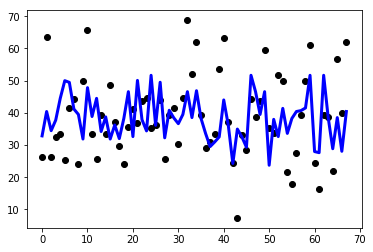

In [14]:
features = ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
m_linear_data = copy.deepcopy(data)
data_tr = m_linear_data
data_tr = data_tr[(data_tr.T != 0).all()]

x_train, y_train, x_test, y_test = split_train_test(data_tr, features)

# Create Linear Regression
reg = LinearRegression()

# train the model using the training sets
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: {}'.format(features))
print('R2: {}'.format(r2_score(y_test, y_pred)))
print('Intercept: {}'.format(reg.intercept_))
print('Coefficients: {}'.format(reg.coef_))

# Ridge Regression

Features: ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2: 0.14413244468387165
Intercept: 71.0204865219637
Coefficients: [ 0.04878308 -0.03738191 -0.15349866  0.22616735 -0.01645943]


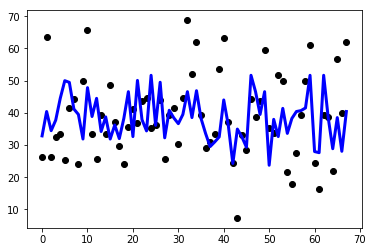

In [17]:
alphas = np.arange(0.1,5,0.1)

model = Ridge()

cv = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))

ridge_data = copy.deepcopy(data)

# x_train, y_train, x_test, y_test = split_train_test(ridge_data, features)

y_pred = cv.fit(x_train, y_train).predict(x_test)

plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: {}'.format(features))
print('R2: {}'.format(r2_score(y_test, y_pred)))
print('Intercept: {}'.format(reg.intercept_))
print('Coefficients: {}'.format(reg.coef_))

# Lasso Regression

Features: ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2: 0.1441536944891797
Intercept: 71.0204865219637
Coefficients: [ 0.04878308 -0.03738191 -0.15349866  0.22616735 -0.01645943]


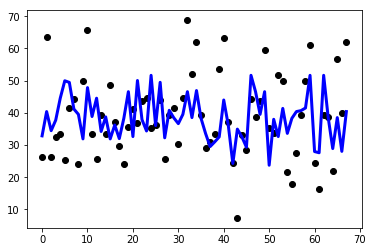

In [16]:
model = Lasso()
cv = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))

y_pred = cv.fit(x_train, y_train).predict(x_test)

plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: {}'.format(features))
print('R2: {}'.format(r2_score(y_test, y_pred)))
print('Intercept: {}'.format(reg.intercept_))
print('Coefficients: {}'.format(reg.coef_))

# ElasticNet

Features: ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2: 0.14414464284974837
Intercept: 71.0204865219637
Coefficients: [ 0.04878308 -0.03738191 -0.15349866  0.22616735 -0.01645943]


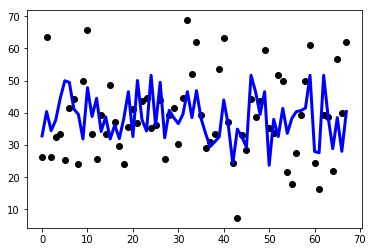

In [18]:
model = ElasticNet()
cv = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas))

y_pred = cv.fit(x_train, y_train).predict(x_test)

plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: {}'.format(features))
print('R2: {}'.format(r2_score(y_test, y_pred)))
print('Intercept: {}'.format(reg.intercept_))
print('Coefficients: {}'.format(reg.coef_))

# Gradient Boosting

C:\Users\MyPC\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


cement_component 0.3126160373291963
fly_ash 0.1007140176973308
water_component 0.3586703010043638
superplasticizer 0.1049806548533706
coarse_aggregate 0.14844944446302244


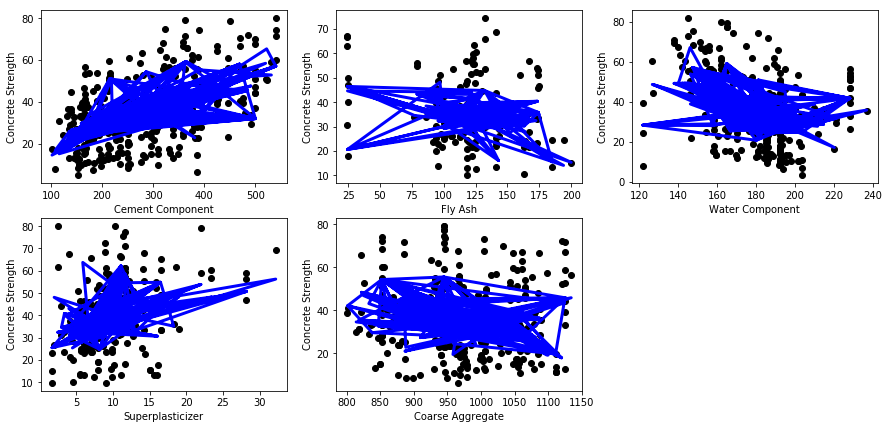

In [19]:
# Simple Gradient Boosting

plt.figure(figsize=(15,7))
plot_count = 1
gradient_data = copy.deepcopy(data)
for feature in ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']:
    data_tr = gradient_data[['concrete_strength', feature]]
    data_tr = data_tr[(data_tr.T != 0).all()]
    
    x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
    
    # Create Linear Regression Object
    reg = GradientBoostingRegressor()

    # Train Model
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)

    # Plot Outputs
    plt.subplot(2,3,plot_count)

    plt.scatter(x_test, y_test, color='black')
    plt.plot(x_test, y_pred, color='blue', linewidth=3)
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel('Concrete Strength')
    print(feature, r2_score(y_test, y_pred))

    plot_count+=1

plt.show()

Features: ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2: 0.14844944446302244


C:\Users\MyPC\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


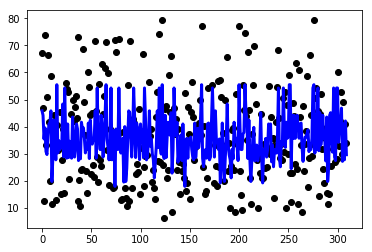

In [22]:
# multiple gradient boosting
model = GradientBoostingRegressor()

y_pred = model.fit(x_train, y_train).predict(x_test)

plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: {}'.format(features))
print('R2: {}'.format(r2_score(y_test, y_pred)))
# print('Intercept: {}'.format(reg.intercept_))
# print('Coefficients: {}'.format(reg.coef_))

# Support Vector Machine Regression

C:\Users\MyPC\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


cement_component 0.24599512723542627
fly_ash 0.05217823564151569
water_component 0.09315196993779784
superplasticizer 0.0491693862167456
coarse_aggregate 0.009287969163983778


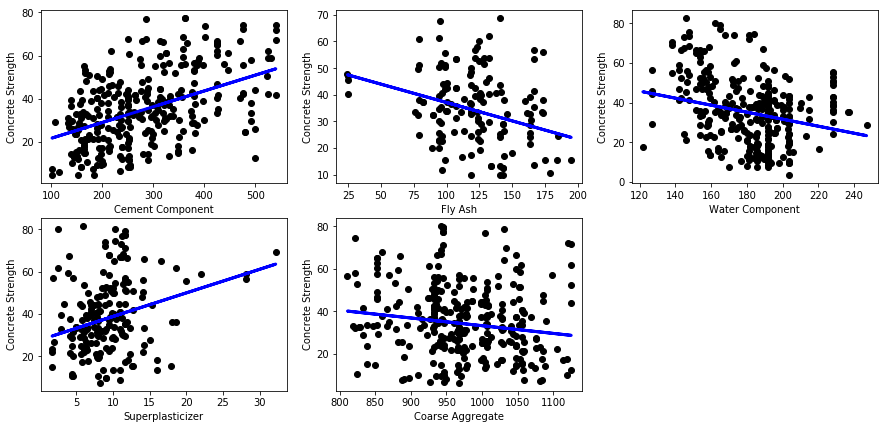

In [23]:
# Simple svr

plt.figure(figsize=(15,7))
plot_count = 1
gradient_data = copy.deepcopy(data)
for feature in ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']:
    data_tr = gradient_data[['concrete_strength', feature]]
    data_tr = data_tr[(data_tr.T != 0).all()]
    
    x_train, y_train, x_test, y_test = split_train_test(data_tr, feature)
    
    # Create Linear Regression Object
    reg = SVR(kernel='linear')

    # Train Model
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)

    # Plot Outputs
    plt.subplot(2,3,plot_count)

    plt.scatter(x_test, y_test, color='black')
    plt.plot(x_test, y_pred, color='blue', linewidth=3)
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel('Concrete Strength')
    print(feature, r2_score(y_test, y_pred))

    plot_count+=1

plt.show()

C:\Users\MyPC\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Features: ['cement_component', 'fly_ash', 'water_component', 'superplasticizer', 'coarse_aggregate']
R2: 0.009287969163983778


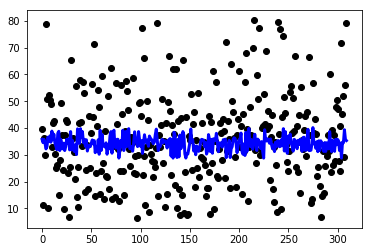

In [24]:
# multiple svr
model = SVR(kernel='linear')

y_pred = model.fit(x_train, y_train).predict(x_test)

plt.scatter(range(len(y_test)), y_test, color='black')
plt.plot(y_pred, color='blue', linewidth=3)

print('Features: {}'.format(features))
print('R2: {}'.format(r2_score(y_test, y_pred)))
# print('Intercept: {}'.format(reg.intercept_))
# print('Coefficients: {}'.format(reg.coef_))